In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score


Veriyi yüklüyor ve ilk 5 satırını inceliyoruz.

In [24]:
df = pd.read_csv("C:/Users/aksan/Downloads/alzheimers_disease_data.csv")
df.head()


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


Veri setindeki eksik değerler ve değişkenlerin tipleri kontrol edilir.

In [25]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

In [41]:
df.dropna(inplace=True)


Tahminle doğrudan ilgisi olmayan kimlik bilgileri kaldırıldı.

In [26]:
df.drop(["PatientID", "DoctorInCharge"], axis=1, inplace=True)


Kategorik Değişkenleri Dönüştürme

In [27]:
# Categorical değişkenleri incele
cat_cols = df.select_dtypes(include=["object"]).columns
print("Kategorik değişkenler:", cat_cols.tolist())

# One-hot encoding (örnek)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Kategorik değişkenler: []


Yeni Değişken Oluşturuldu.

In [28]:
bins_age = [0, 60, 70, 80, 90, 150]
labels_age = ['<60', '60-69', '70-79', '80-89', '90+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age)




BMI üzerinden sağlık durumu

In [29]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'


In [30]:
df['BMICategory'] = df['BMI'].apply(bmi_category)


Sigara ve alkol etkileşim terimi

In [31]:
df['Smoke_Alcohol_Interaction'] = df['Smoking'] * df['AlcoholConsumption']

Fiziksel aktivite ve diyet kalitesinden sağlık skoru 
Fiziksel aktivite ve diyet kalitesi normalize edilip toplam skor

In [32]:
scaler_minmax = MinMaxScaler()
df[['PhysicalActivity_Scaled', 'DietQuality_Scaled']] = scaler_minmax.fit_transform(
    df[['PhysicalActivity', 'DietQuality']])

In [33]:
df['HealthScore'] = df['PhysicalActivity_Scaled'] + df['DietQuality_Scaled']

Eğitim ve etnik köken kombinasyonu ile risk skoru 
Eğitim seviyesi ve etnik kökeni birleştirip risk oluşturma

In [34]:
df['EduEthnicity_Risk'] = df['EducationLevel'] * (df['Ethnicity'] + 1)  # +1 eksik değer olmaması için

Belirti bazlı özet skorlar
Hafıza, davranış, karışıklık vb. belirtileri toplama

In [35]:
symptoms = ['MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 
            'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
df['Symptom_Score'] = df[symptoms].sum(axis=1)

Standartlaştırma 

In [36]:
num_cols = ['Age', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'HealthScore', 'Symptom_Score']
scaler = StandardScaler()
df[[col + '_scaled' for col in num_cols]] = scaler.fit_transform(df[num_cols])


Binarizasyon
BMI 25 üzeri -> 1, değilse 0

In [37]:
df['IsOverweight'] = (df['BMI'] >= 25).astype(int)


Polinom ve etkileşim özellikleri

In [38]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[['Age', 'BMI', 'Smoking', 'AlcoholConsumption']])
poly_feature_names = poly.get_feature_names_out(['Age', 'BMI', 'Smoking', 'AlcoholConsumption'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

In [39]:
df = pd.concat([df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

Kategorik değişkenlerin one-hot encoding

In [42]:
categorical_cols = ['Gender', 'Ethnicity', 'AgeGroup', 'BMICategory']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [43]:
print(df.head())


   Age  EducationLevel        BMI  Smoking  AlcoholConsumption  \
0   73               2  22.927749        0           13.297218   
1   89               0  26.827681        0            4.542524   
2   73               1  17.795882        0           19.555085   
3   74               1  33.800817        1           12.209266   
4   89               0  20.716974        0           18.454356   

   PhysicalActivity  DietQuality  SleepQuality  FamilyHistoryAlzheimers  \
0          6.327112     1.347214      9.025679                        0   
1          7.619885     0.518767      7.151293                        0   
2          7.844988     1.826335      9.673574                        1   
3          8.428001     7.435604      8.392554                        0   
4          6.310461     0.795498      5.597238                        0   

   CardiovascularDisease  ...  Ethnicity_1  Ethnicity_2  Ethnicity_3  \
0                      0  ...        False        False        False   
1       

 Korelasyon Matrisi oluşturuldu.

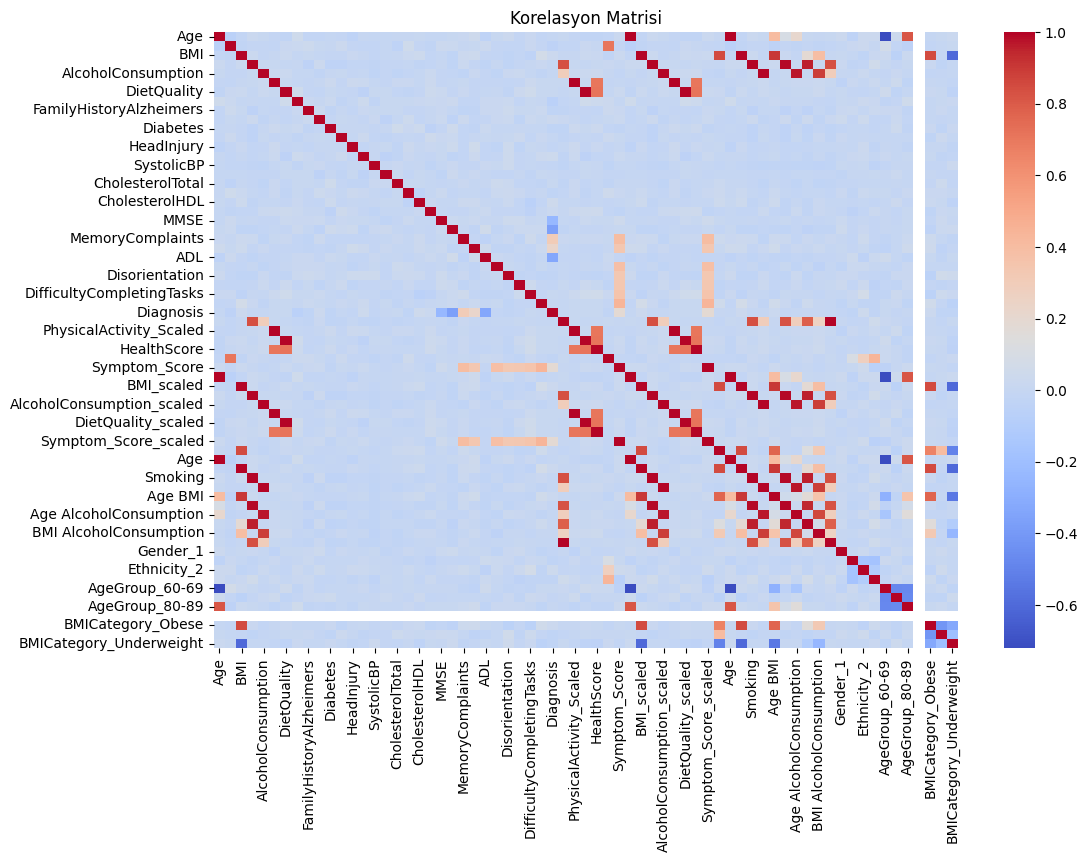

In [44]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()


Diagnosis hedef değişken olarak belirlendi.

In [45]:
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]


Sayısal veriler standartlaştırılarak model için uygun hale getirildi.

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Veri seti %80 eğitim, %20 test olacak şekilde ikiye ayrıldı.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


 Random Forest algoritması ile model eğitildi.

In [49]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Modelin sınıflandırma başarımı doğruluk, f1, precision ve recall metrikleri ile ölçüldü.

In [50]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[272   5]
 [ 34 119]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       277
           1       0.96      0.78      0.86       153

    accuracy                           0.91       430
   macro avg       0.92      0.88      0.90       430
weighted avg       0.91      0.91      0.91       430



Gerçek ve tahmin edilen sınıflar arasındaki karşılaştırma görselleştirildi.

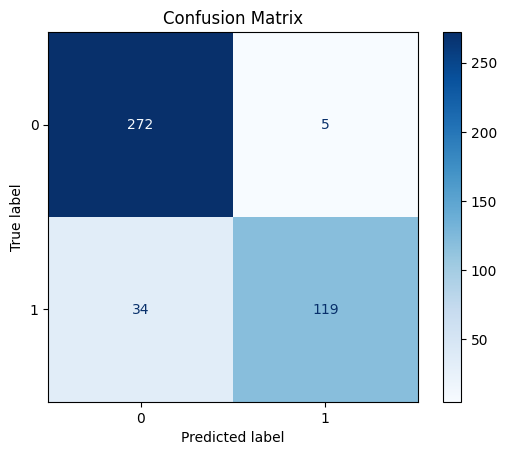

In [51]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


ROC eğrisi modeli hasta sınıfını ne kadar başarılı ayırabildiğini gösterir. AUC ne kadar 1'e yakınsa o kadar iyidir.



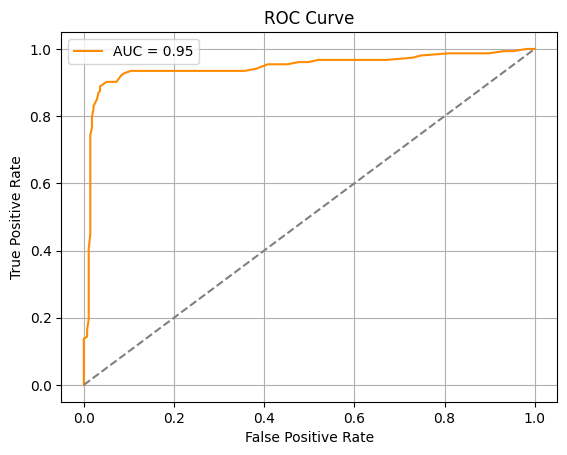

In [52]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
